In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("="*80)
print("SNACKFAST QSR STORE SITE SELECTION - MAHARASHTRA")
print("="*80)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80)

SNACKFAST QSR STORE SITE SELECTION - MAHARASHTRA
Analysis Date: 2025-10-29 07:37:57


In [14]:
# ============================================================================
# PHASE 1: DATA ACQUISITION AND PREPARATION
# ============================================================================
print("\n" + "="*80)
print("PHASE 1: DATA ACQUISITION AND PREPARATION")
print("="*80)

# Step 1.1: Load Data Layer 1 (Pincode/Census Data)
print("\n[Step 1.1] Loading Data Layer 1 - Pincode/Census Data...")
try:
    # Load your first CSV file
    df_pincode = pd.read_csv('/content/5c2f62fe-5afa-4119-a499-fec9d604d5bd.csv')
    print(f"✓ Data Layer 1 loaded: {df_pincode.shape[0]} rows, {df_pincode.shape[1]} columns")
    print(f"  Columns: {list(df_pincode.columns)}")
except Exception as e:
    print(f"✗ Error loading Data Layer 1: {e}")
    df_pincode = None

# Step 1.2: Load Data Layer 2 (POI/Competition Data)
print("\n[Step 1.2] Loading Data Layer 2 - POI/Competition Data...")
try:
    df_poi = pd.read_csv('/content/consolidated_pincode_census.csv')
    print(f"✓ Data Layer 2 loaded: {df_poi.shape[0]} rows, {df_poi.shape[1]} columns")
    print(f"  Columns: {list(df_poi.columns)}")
except Exception as e:
    print(f"✗ Error loading Data Layer 2: {e}")
    df_poi = None

# Step 1.3: Data Inspection
print("\n[Step 1.3] Initial Data Inspection...")
if df_pincode is not None:
    print("\n--- Data Layer 1 Preview ---")
    print(df_pincode.head())
    print(f"\nData Types:\n{df_pincode.dtypes}")
    print(f"\nMissing Values:\n{df_pincode.isnull().sum()}")

if df_poi is not None:
    print("\n--- Data Layer 2 Preview ---")
    print(df_poi.head())
    print(f"\nData Types:\n{df_poi.dtypes}")
    print(f"\nMissing Values:\n{df_poi.isnull().sum()}")

# Step 1.4: Filter Maharashtra Data
print("\n[Step 1.4] Filtering Maharashtra Data...")

# Identify state column (could be 'State', 'StateName', 'state', etc.)
if df_pincode is not None:
    state_col = None
    for col in df_pincode.columns:
        if 'state' in col.lower():
            state_col = col
            break

    if state_col:
        print(f"  Using column '{state_col}' for state filtering")
        # Filter Maharashtra
        df_pincode_mh = df_pincode[
            df_pincode[state_col].str.upper().str.contains('MAHARASHTRA', na=False)
        ].copy()
        print(f"✓ Maharashtra records in Layer 1: {len(df_pincode_mh)}")
    else:
        print("  No state column found, using pincode prefix filtering...")
        # Maharashtra pincodes start with 4
        pincode_col = [col for col in df_pincode.columns if 'pincode' in col.lower()][0]
        df_pincode_mh = df_pincode[
            df_pincode[pincode_col].astype(str).str.startswith('4')
        ].copy()
        print(f"✓ Maharashtra records (by pincode): {len(df_pincode_mh)}")

# Filter POI data for Maharashtra (pincodes starting with 4)
if df_poi is not None:
    pincode_col_poi = [col for col in df_poi.columns if 'pincode' in col.lower()][0]
    df_poi_mh = df_poi[
        df_poi[pincode_col_poi].astype(str).str.startswith('4')
    ].copy()
    print(f"✓ Maharashtra POI records: {len(df_poi_mh)}")

# Step 1.5: Standardize Pincode Field
print("\n[Step 1.5] Standardizing Pincode Fields...")

def standardize_pincode(df, pincode_col):
    """Standardize pincode to 6-digit string format"""
    df = df.copy()

    # Convert to string and remove decimals
    df[pincode_col] = df[pincode_col].astype(str).str.replace('.0', '', regex=False)

    # Remove whitespace
    df[pincode_col] = df[pincode_col].str.strip()

    # Keep only 6-digit pincodes
    df[pincode_col] = df[pincode_col].apply(lambda x: x if len(x) == 6 and x.isdigit() else np.nan)

    # Remove invalid pincodes
    initial_count = len(df)
    df = df.dropna(subset=[pincode_col])
    removed = initial_count - len(df)

    print(f"  Removed {removed} records with invalid pincodes")
    print(f"  Valid pincodes remaining: {len(df)}")

    return df

# Standardize both datasets
if df_pincode_mh is not None:
    pincode_col_1 = [col for col in df_pincode_mh.columns if 'pincode' in col.lower()][0]
    df_pincode_clean = standardize_pincode(df_pincode_mh, pincode_col_1)
    print(f"✓ Data Layer 1 cleaned: {len(df_pincode_clean)} records")

if df_poi_mh is not None:
    pincode_col_2 = [col for col in df_poi_mh.columns if 'pincode' in col.lower()][0]
    df_poi_clean = standardize_pincode(df_poi_mh, pincode_col_2)
    print(f"✓ Data Layer 2 cleaned: {len(df_poi_clean)} records")

# Step 1.6: Data Fusion - Merge Datasets
print("\n[Step 1.6] Data Fusion - Merging Datasets...")

# First, aggregate pincode data (handle multiple post offices per pincode)
print("  Aggregating Data Layer 1 by Pincode...")

# Identify relevant columns
district_col = [col for col in df_pincode_clean.columns if 'district' in col.lower()][0]

# Try to find population/household column
pop_col = None
for col in df_pincode_clean.columns:
    if any(x in col.lower() for x in ['population', 'households', 'families']):
        pop_col = col
        break

# Aggregate pincode data
if pop_col:
    print(f"  Found population/household column: {pop_col}")
    df_pincode_agg = df_pincode_clean.groupby(pincode_col_1).agg({
        district_col: 'first',
        pop_col: 'sum'
    }).reset_index()
    df_pincode_agg.columns = ['Pincode', 'District', 'Population']
else:
    print("  No population column found. Using post office count as proxy...")
    df_pincode_agg = df_pincode_clean.groupby(pincode_col_1).agg({
        district_col: ['first', 'count']
    }).reset_index()
    df_pincode_agg.columns = ['Pincode', 'District', 'OfficeCount']
    # Estimate population: assume 5000 people per post office
    df_pincode_agg['Population'] = df_pincode_agg['OfficeCount'] * 5000

print(f"  Aggregated to {len(df_pincode_agg)} unique pincodes")

# Aggregate POI data (count of POIs per pincode)
print("  Aggregating Data Layer 2 by Pincode...")
df_poi_agg = df_poi_clean.groupby(pincode_col_2).size().reset_index(name='POI_Count')
df_poi_agg.columns = ['Pincode', 'POI_Count']
print(f"  Aggregated to {len(df_poi_agg)} unique pincodes with POIs")

# Merge the datasets
print("  Merging datasets on Pincode...")
df_master = pd.merge(
    df_pincode_agg,
    df_poi_agg,
    on='Pincode',
    how='left'
)

# Fill missing POI counts with 0
df_master['POI_Count'] = df_master['POI_Count'].fillna(0).astype(int)

print(f"✓ Master dataset created: {len(df_master)} records")
print(f"\nMaster Dataset Preview:")
print(df_master.head(10))


PHASE 1: DATA ACQUISITION AND PREPARATION

[Step 1.1] Loading Data Layer 1 - Pincode/Census Data...
✓ Data Layer 1 loaded: 165627 rows, 11 columns
  Columns: ['circlename', 'regionname', 'divisionname', 'officename', 'pincode', 'officetype', 'delivery', 'district', 'statename', 'latitude', 'longitude']

[Step 1.2] Loading Data Layer 2 - POI/Competition Data...
✓ Data Layer 2 loaded: 17392 rows, 83 columns
  Columns: ['Unnamed: 0', 'pincode', 'district_key', 'District', 'Persons', 'Males', 'Females', 'Growth..1991...2001.', 'Rural', 'Urban', 'Scheduled.Caste.population', 'Percentage...SC.to.total', 'Number.of.households', 'Household.size..per.household.', 'Sex.ratio..females.per.1000.males.', 'Sex.ratio..0.6.years.', 'Scheduled.Tribe.population', 'Percentage.to.total.population..ST.', 'Persons..literate', 'Males..Literate', 'Females..Literate', 'Persons..literacy.rate', 'Males..Literatacy.Rate', 'Females..Literacy.Rate', 'Total.Educated', 'Data.without.level', 'Below.Primary', 'Primary

In [15]:

# ============================================================================
# PHASE 2: BUSINESS LOGIC AND FEATURE CREATION
# ============================================================================
print("\n" + "="*80)
print("PHASE 2: BUSINESS LOGIC AND FEATURE CREATION")
print("="*80)

# Step 2.1: Calculate Competitive Density Index (CDI)
print("\n[Step 2.1] Calculating Competitive Density Index (CDI)...")
print("  Formula: CDI = (Count of Competing POIs / Population) * 10,000")

df_master['CDI'] = (df_master['POI_Count'] / df_master['Population']) * 10000
df_master['CDI'] = df_master['CDI'].round(2)

print(f"✓ CDI calculated for all pincodes")
print(f"  CDI Range: {df_master['CDI'].min():.2f} to {df_master['CDI'].max():.2f}")
print(f"  CDI Mean: {df_master['CDI'].mean():.2f}")
print(f"  CDI Median: {df_master['CDI'].median():.2f}")

# Step 2.2: Logistics Risk Assessment
print("\n[Step 2.2] Calculating Logistics Risk Score...")
print("  Logic based on first 2 digits of Pincode:")
print("    40-42 (Mumbai/Pune Metro): Low Risk = 3")
print("    42-43 (Nashik/Aurangabad): Medium Risk = 5")
print("    44+ (Remote Areas): High Risk = 8")

def calculate_logistics_risk(pincode):
    """Calculate logistics risk based on pincode prefix"""
    first_two = int(str(pincode)[:2])

    if 40 <= first_two <= 41:  # Mumbai/Pune
        return 3, 'Low'
    elif 42 <= first_two <= 43:  # Nashik/Aurangabad
        return 5, 'Medium'
    else:  # Remote areas
        return 8, 'High'

df_master['Logistics_Risk_Score'] = df_master['Pincode'].apply(
    lambda x: calculate_logistics_risk(x)[0]
)
df_master['Logistics_Risk_Category'] = df_master['Pincode'].apply(
    lambda x: calculate_logistics_risk(x)[1]
)

print(f"✓ Logistics Risk Score calculated")
print(f"\nRisk Distribution:")
print(df_master['Logistics_Risk_Category'].value_counts())

# Step 2.3: Final Classification - High Viability Pincode
print("\n[Step 2.3] Defining High Viability Pincodes...")
print("  Criteria: CDI < 5 AND Logistics_Risk_Score <= 5")

# Create viability score (composite metric)
df_master['Viability_Score'] = (
    0.6 * df_master['CDI'] +
    0.4 * df_master['Logistics_Risk_Score']
)
df_master['Viability_Score'] = df_master['Viability_Score'].round(2)

# High viability classification
df_master['High_Viability'] = (
    (df_master['CDI'] < 5) &
    (df_master['Logistics_Risk_Score'] <= 5)
)

print(f"✓ Viability classification completed")
print(f"  High Viability Pincodes: {df_master['High_Viability'].sum()}")
print(f"  Percentage: {(df_master['High_Viability'].sum()/len(df_master)*100):.1f}%")

# Filter for minimum population threshold
MIN_POPULATION = 10000
df_master_filtered = df_master[df_master['Population'] >= MIN_POPULATION].copy()
print(f"\nFiltered for population >= {MIN_POPULATION}: {len(df_master_filtered)} pincodes")


PHASE 2: BUSINESS LOGIC AND FEATURE CREATION

[Step 2.1] Calculating Competitive Density Index (CDI)...
  Formula: CDI = (Count of Competing POIs / Population) * 10,000
✓ CDI calculated for all pincodes
  CDI Range: 0.00 to 4.00
  CDI Mean: 0.56
  CDI Median: 0.29

[Step 2.2] Calculating Logistics Risk Score...
  Logic based on first 2 digits of Pincode:
    40-42 (Mumbai/Pune Metro): Low Risk = 3
    42-43 (Nashik/Aurangabad): Medium Risk = 5
    44+ (Remote Areas): High Risk = 8
✓ Logistics Risk Score calculated

Risk Distribution:
Logistics_Risk_Category
Low       909
Medium    384
High      307
Name: count, dtype: int64

[Step 2.3] Defining High Viability Pincodes...
  Criteria: CDI < 5 AND Logistics_Risk_Score <= 5
✓ Viability classification completed
  High Viability Pincodes: 1293
  Percentage: 80.8%

Filtered for population >= 10000: 1423 pincodes


In [16]:

# ============================================================================
# PHASE 3: TOP 3 RECOMMENDATIONS
# ============================================================================
print("\n" + "="*80)
print("PHASE 3: TOP 3 PINCODE RECOMMENDATIONS")
print("="*80)

# Sort by viability score (lower is better)
df_recommendations = df_master_filtered.sort_values('Viability_Score').head(3)

print("\n🏆 TOP 3 RECOMMENDED PINCODES FOR SNACKFAST DARK STORE:\n")
for idx, row in df_recommendations.iterrows():
    print(f"\nRank #{df_recommendations.index.get_loc(idx) + 1}: Pincode {row['Pincode']}")
    print(f"   District: {row['District']}")
    print(f"   Population: {row['Population']:,}")
    print(f"   Competing POIs: {row['POI_Count']}")
    print(f"   CDI: {row['CDI']:.2f}")
    print(f"   Logistics Risk: {row['Logistics_Risk_Category']} ({row['Logistics_Risk_Score']})")
    print(f"   Viability Score: {row['Viability_Score']:.2f}")
    print(f"   High Viability: {'Yes' if row['High_Viability'] else 'No'}")

# Save master dataset
df_master_filtered.to_csv('snackfast_site_analysis_master.csv', index=False)
print(f"\n✓ Master analysis dataset saved: snackfast_site_analysis_master.csv")

# Save top 3 recommendations
df_recommendations.to_csv('snackfast_top3_recommendations.csv', index=False)
print(f"✓ Top 3 recommendations saved: snackfast_top3_recommendations.csv")


PHASE 3: TOP 3 PINCODE RECOMMENDATIONS

🏆 TOP 3 RECOMMENDED PINCODES FOR SNACKFAST DARK STORE:


Rank #1: Pincode 400001
   District: MUMBAI
   Population: 30,000
   Competing POIs: 0
   CDI: 0.00
   Logistics Risk: Low (3)
   Viability Score: 1.20
   High Viability: Yes

Rank #2: Pincode 400702
   District: RAIGAD
   Population: 35,000
   Competing POIs: 0
   CDI: 0.00
   Logistics Risk: Low (3)
   Viability Score: 1.20
   High Viability: Yes

Rank #3: Pincode 400707
   District: RAIGAD
   Population: 15,000
   Competing POIs: 0
   CDI: 0.00
   Logistics Risk: Low (3)
   Viability Score: 1.20
   High Viability: Yes

✓ Master analysis dataset saved: snackfast_site_analysis_master.csv
✓ Top 3 recommendations saved: snackfast_top3_recommendations.csv



PHASE 3: VISUALIZATION & DASHBOARD CREATION

[Visualization 1] Creating CDI vs Logistics Risk Scatter Plot...
✓ Visualization 1 complete
[Visualization 2] Creating Top 20 Pincodes Bar Chart...
✓ Visualization 2 complete
[Visualization 3] Creating District-wise Summary...
✓ Visualization 3a complete
[Visualization 4] Creating Risk Distribution Pie Chart...
✓ Visualization 3b complete

✓ Dashboard saved: snackfast_dashboard.png


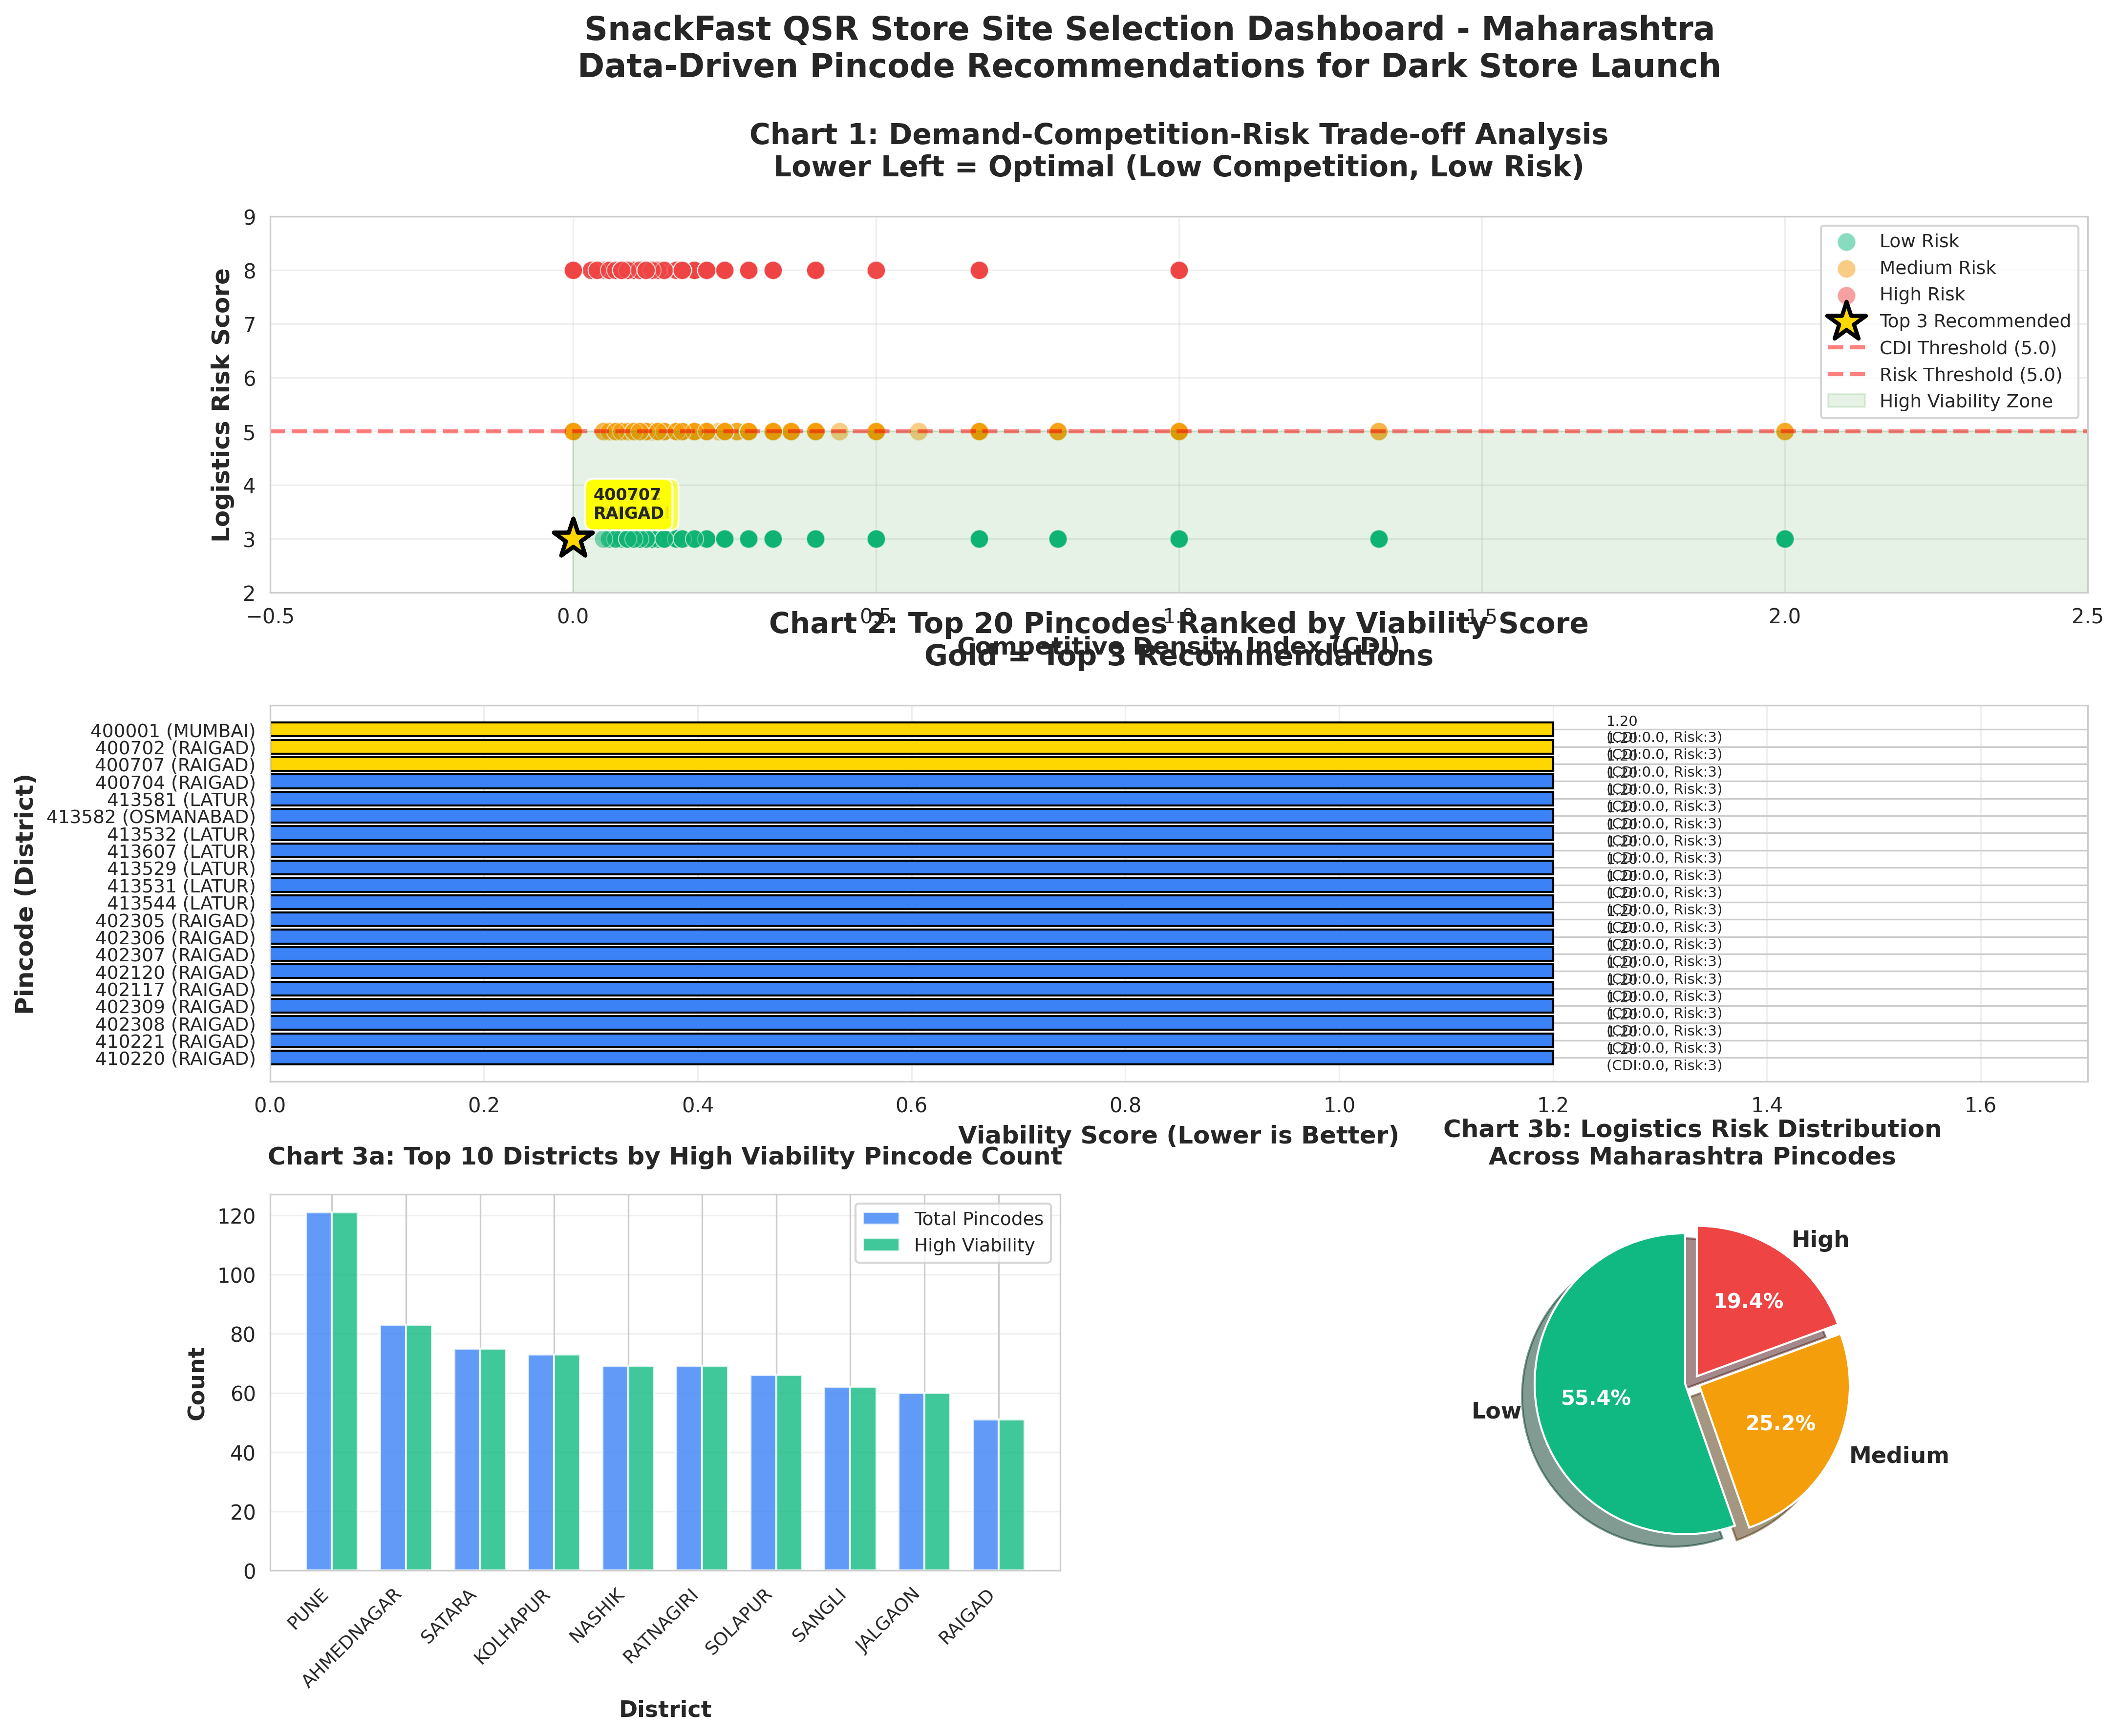

In [18]:

# ============================================================================
# PHASE 4: VISUALIZATION, RECOMMENDATION, AND DASHBOARD
# ============================================================================
print("\n" + "="*80)
print("PHASE 3: VISUALIZATION & DASHBOARD CREATION")
print("="*80)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up the visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'

# Create figure with 3 subplots
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)


# ============================================================================
# VISUALIZATION 1: COMPETITIVE DENSITY vs LOGISTICS RISK (Scatter Plot)
# ============================================================================
print("\n[Visualization 1] Creating CDI vs Logistics Risk Scatter Plot...")

ax1 = fig.add_subplot(gs[0, :])

# Color mapping for risk categories
risk_colors = {'Low': '#10b981', 'Medium': '#f59e0b', 'High': '#ef4444'}

# Plot all points
for risk_cat in ['Low', 'Medium', 'High']:
    mask = df_master_filtered['Logistics_Risk_Category'] == risk_cat
    subset = df_master_filtered[mask]
    ax1.scatter(subset['CDI'], subset['Logistics_Risk_Score'],
               alpha=0.5, s=80, c=risk_colors[risk_cat],
               label=f'{risk_cat} Risk', edgecolors='white', linewidth=0.5)

# Highlight top 3 recommendations
top3 = df_master_filtered.sort_values('Viability_Score').head(3)
ax1.scatter(top3['CDI'], top3['Logistics_Risk_Score'],
           s=400, c='gold', marker='*', edgecolors='black',
           linewidth=2, label='Top 3 Recommended', zorder=10)

# Add annotations for top 3
for idx, row in top3.iterrows():
    ax1.annotate(f"{row['Pincode']}\n{row['District']}",
                xy=(row['CDI'], row['Logistics_Risk_Score']),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
                fontsize=8, fontweight='bold')

# Add viability zone
ax1.axvline(x=5, color='red', linestyle='--', linewidth=2, alpha=0.5, label='CDI Threshold (5.0)')
ax1.axhline(y=5, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Risk Threshold (5.0)')

# Shade high viability zone
ax1.fill_between([0, 5], 0, 5, alpha=0.1, color='green', label='High Viability Zone')

ax1.set_xlabel('Competitive Density Index (CDI)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Logistics Risk Score', fontsize=12, fontweight='bold')
ax1.set_title('Chart 1: Demand-Competition-Risk Trade-off Analysis\nLower Left = Optimal (Low Competition, Low Risk)',
             fontsize=14, fontweight='bold', pad=20)
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-0.5, df_master_filtered['CDI'].max() + 0.5)
ax1.set_ylim(2, 9)

print("✓ Visualization 1 complete")

# ============================================================================
# VISUALIZATION 2: TOP 20 PINCODES BY VIABILITY SCORE (Bar Chart)
# ============================================================================
print("[Visualization 2] Creating Top 20 Pincodes Bar Chart...")

ax2 = fig.add_subplot(gs[1, :])

# Get top 20 pincodes
top20 = df_master_filtered.sort_values('Viability_Score').head(20)

# Create bar chart
bars = ax2.barh(range(len(top20)), top20['Viability_Score'],
                color=['#FFD700' if i < 3 else '#3b82f6' for i in range(len(top20))],
                edgecolor='black', linewidth=1)

# Add pincode labels
labels = [f"{row['Pincode']} ({row['District']})" for _, row in top20.iterrows()]
ax2.set_yticks(range(len(top20)))
ax2.set_yticklabels(labels, fontsize=9)

# Add value labels on bars
for i, (idx, row) in enumerate(top20.iterrows()):
    ax2.text(row['Viability_Score'] + 0.05, i,
            f"{row['Viability_Score']:.2f}\n(CDI:{row['CDI']:.1f}, Risk:{row['Logistics_Risk_Score']})",
            va='center', fontsize=7)

ax2.set_xlabel('Viability Score (Lower is Better)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Pincode (District)', fontsize=12, fontweight='bold')
ax2.set_title('Chart 2: Top 20 Pincodes Ranked by Viability Score\nGold = Top 3 Recommendations',
             fontsize=14, fontweight='bold', pad=20)
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3, axis='x')
ax2.set_xlim(0, top20['Viability_Score'].max() + 0.5)

print("✓ Visualization 2 complete")

# ============================================================================
# VISUALIZATION 3: DISTRICT-WISE ANALYSIS (Grouped Bar Chart)
# ============================================================================
print("[Visualization 3] Creating District-wise Summary...")

ax3 = fig.add_subplot(gs[2, 0])

# Aggregate by district
district_stats = df_master_filtered.groupby('District').agg({
    'Pincode': 'count',
    'Population': 'sum',
    'CDI': 'mean',
    'High_Viability': 'sum'
}).reset_index()
district_stats.columns = ['District', 'Pincode_Count', 'Total_Population', 'Avg_CDI', 'High_Viability_Count']
district_stats = district_stats.sort_values('High_Viability_Count', ascending=False).head(10)

# Create grouped bar chart
x = np.arange(len(district_stats))
width = 0.35

bars1 = ax3.bar(x - width/2, district_stats['Pincode_Count'], width,
               label='Total Pincodes', color='#3b82f6', alpha=0.8)
bars2 = ax3.bar(x + width/2, district_stats['High_Viability_Count'], width,
               label='High Viability', color='#10b981', alpha=0.8)

ax3.set_xlabel('District', fontsize=11, fontweight='bold')
ax3.set_ylabel('Count', fontsize=11, fontweight='bold')
ax3.set_title('Chart 3a: Top 10 Districts by High Viability Pincode Count',
             fontsize=12, fontweight='bold', pad=15)
ax3.set_xticks(x)
ax3.set_xticklabels(district_stats['District'], rotation=45, ha='right', fontsize=9)
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3, axis='y')

print("✓ Visualization 3a complete")

# ============================================================================
# VISUALIZATION 4: RISK DISTRIBUTION (Pie Chart)
# ============================================================================
print("[Visualization 4] Creating Risk Distribution Pie Chart...")

ax4 = fig.add_subplot(gs[2, 1])

risk_dist = df_master_filtered['Logistics_Risk_Category'].value_counts()
colors_pie = ['#10b981', '#f59e0b', '#ef4444']

wedges, texts, autotexts = ax4.pie(risk_dist.values,
                                     labels=risk_dist.index,
                                     autopct='%1.1f%%',
                                     colors=colors_pie,
                                     startangle=90,
                                     explode=(0.05, 0.05, 0.05),
                                     shadow=True)

# Enhance text
for text in texts:
    text.set_fontsize(11)
    text.set_fontweight('bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')

ax4.set_title('Chart 3b: Logistics Risk Distribution\nAcross Maharashtra Pincodes',
             fontsize=12, fontweight='bold', pad=15)

print("✓ Visualization 3b complete")

# Add main title
fig.suptitle('SnackFast QSR Store Site Selection Dashboard - Maharashtra\nData-Driven Pincode Recommendations for Dark Store Launch',
            fontsize=16, fontweight='bold', y=0.995)

# Save dashboard
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.savefig('snackfast_dashboard.png', dpi=300, bbox_inches='tight', facecolor='white')
print("\n✓ Dashboard saved: snackfast_dashboard.png")

plt.show()







In [20]:
import os, matplotlib.pyplot as plt, seaborn as sns, numpy as np
os.makedirs('/content/out_q2_small', exist_ok=True)
sns.set_style("whitegrid")

df = df_master_filtered.copy()
top20 = df.sort_values('Viability_Score').head(20)
district_stats = df.groupby('District').agg({
    'Pincode':'count','Population':'sum','CDI':'mean','High_Viability':'sum'
}).reset_index().rename(columns={'Pincode':'Pincode_Count','High_Viability':'High_Viability_Count'})
district_stats = district_stats.sort_values('High_Viability_Count', ascending=False).head(10)

# -------- Chart 1: CDI vs Risk (smaller scatter)
plt.figure(figsize=(8,6))
colors = {'Low':'#10b981','Medium':'#f59e0b','High':'#ef4444'}
for rcat in colors:
    sub = df[df['Logistics_Risk_Category']==rcat]
    plt.scatter(sub['CDI'], sub['Logistics_Risk_Score'], s=60, alpha=0.6,
                color=colors[rcat], label=f'{rcat} Risk', edgecolor='k', linewidth=0.3)
t3 = df.sort_values('Viability_Score').head(3)
plt.scatter(t3['CDI'], t3['Logistics_Risk_Score'], s=200, color='gold', marker='*',
            edgecolor='black', linewidth=1)
plt.axvline(5, color='red', ls='--', lw=1)
plt.axhline(5, color='red', ls='--', lw=1)
plt.fill_betweenx([0,5], 0, 5, color='green', alpha=0.08)
plt.xlabel('CDI', fontsize=12, weight='bold')
plt.ylabel('Risk Score', fontsize=12, weight='bold')
plt.title('CDI vs Logistics Risk', fontsize=13, weight='bold')
plt.legend(fontsize=9)
plt.tight_layout()
plt.savefig('/content/out_q2_small/cdi_vs_risk_small.png', dpi=300)
plt.close()

# -------- Chart 2: Top 20 Pincodes
plt.figure(figsize=(8,6))
labels = [f"{int(r['Pincode'])} ({r['District']})" for _, r in top20.iterrows()]
plt.barh(range(len(top20)), top20['Viability_Score'],
         color=['#FFD700' if i<3 else '#3b82f6' for i in range(len(top20))],
         edgecolor='k')
plt.yticks(range(len(top20)), labels, fontsize=8)
plt.xlabel('Viability Score ↓', fontsize=11, weight='bold')
plt.title('Top 20 Pincodes by Viability', fontsize=13, weight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('/content/out_q2_small/top20_viability_small.png', dpi=300)
plt.close()

# -------- Chart 3: District summary
plt.figure(figsize=(8,5))
x = np.arange(len(district_stats))
plt.bar(x-0.15, district_stats['Pincode_Count'], width=0.3, label='Total', color='#3b82f6')
plt.bar(x+0.15, district_stats['High_Viability_Count'], width=0.3, label='High Viability', color='#10b981')
plt.xticks(x, district_stats['District'], rotation=45, ha='right', fontsize=8)
plt.ylabel('Count', fontsize=11, weight='bold')
plt.title('Top 10 Districts by High Viability', fontsize=13, weight='bold')
plt.legend(fontsize=9)
plt.tight_layout()
plt.savefig('/content/out_q2_small/district_viability_small.png', dpi=300)
plt.close()

# -------- Chart 4: Risk distribution (pie)
plt.figure(figsize=(6,6))
risk_dist = df['Logistics_Risk_Category'].value_counts()
plt.pie(risk_dist.values, labels=risk_dist.index, autopct='%1.1f%%',
        colors=['#10b981','#f59e0b','#ef4444'], startangle=90,
        explode=(0.03,0.03,0.03), textprops={'fontsize':10,'weight':'bold'})
plt.title('Logistics Risk Distribution', fontsize=13, weight='bold')
plt.tight_layout()
plt.savefig('/content/out_q2_small/risk_distribution_small.png', dpi=300)
plt.close()

print("Saved medium-sized charts to /content/out_q2_small:")
print(sorted(os.listdir('/content/out_q2_small')))


Saved medium-sized charts to /content/out_q2_small:
['cdi_vs_risk_small.png', 'district_viability_small.png', 'risk_distribution_small.png', 'top20_viability_small.png']


In [21]:
import os, matplotlib.pyplot as plt, seaborn as sns, numpy as np
os.makedirs('/content/out_q2_small', exist_ok=True)


Showing: cdi_vs_risk_small.png


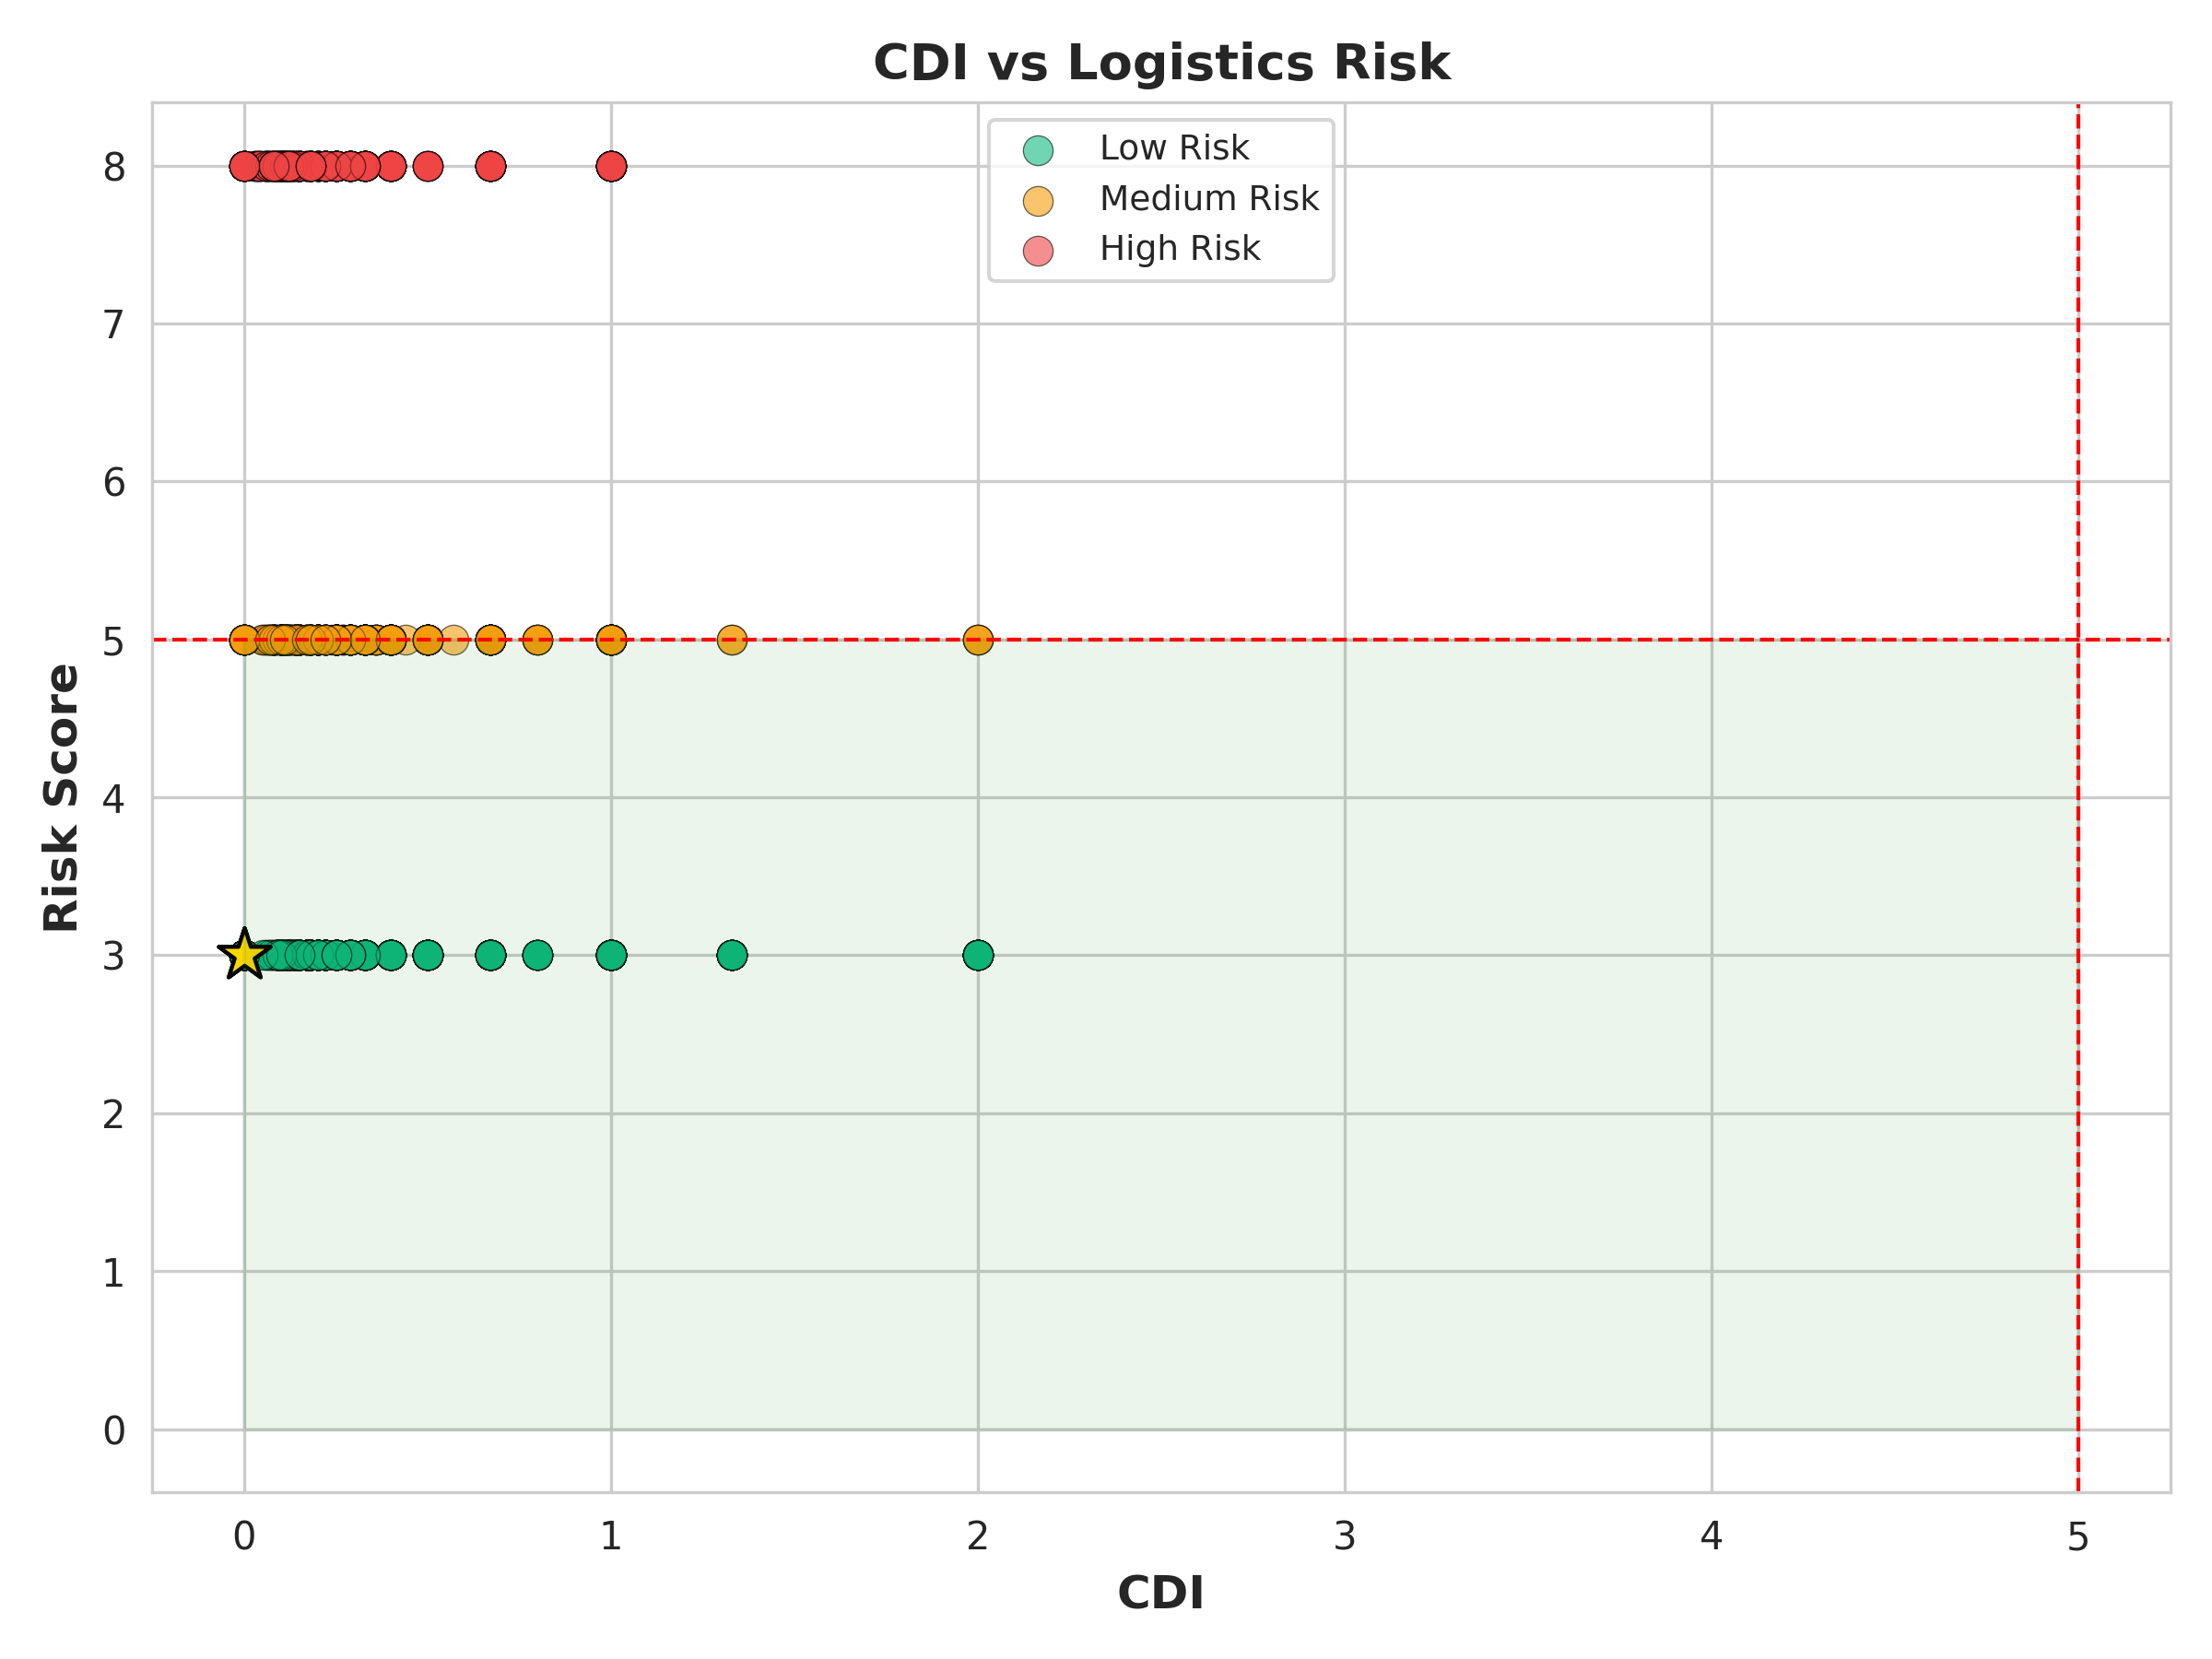

Showing: district_viability_small.png


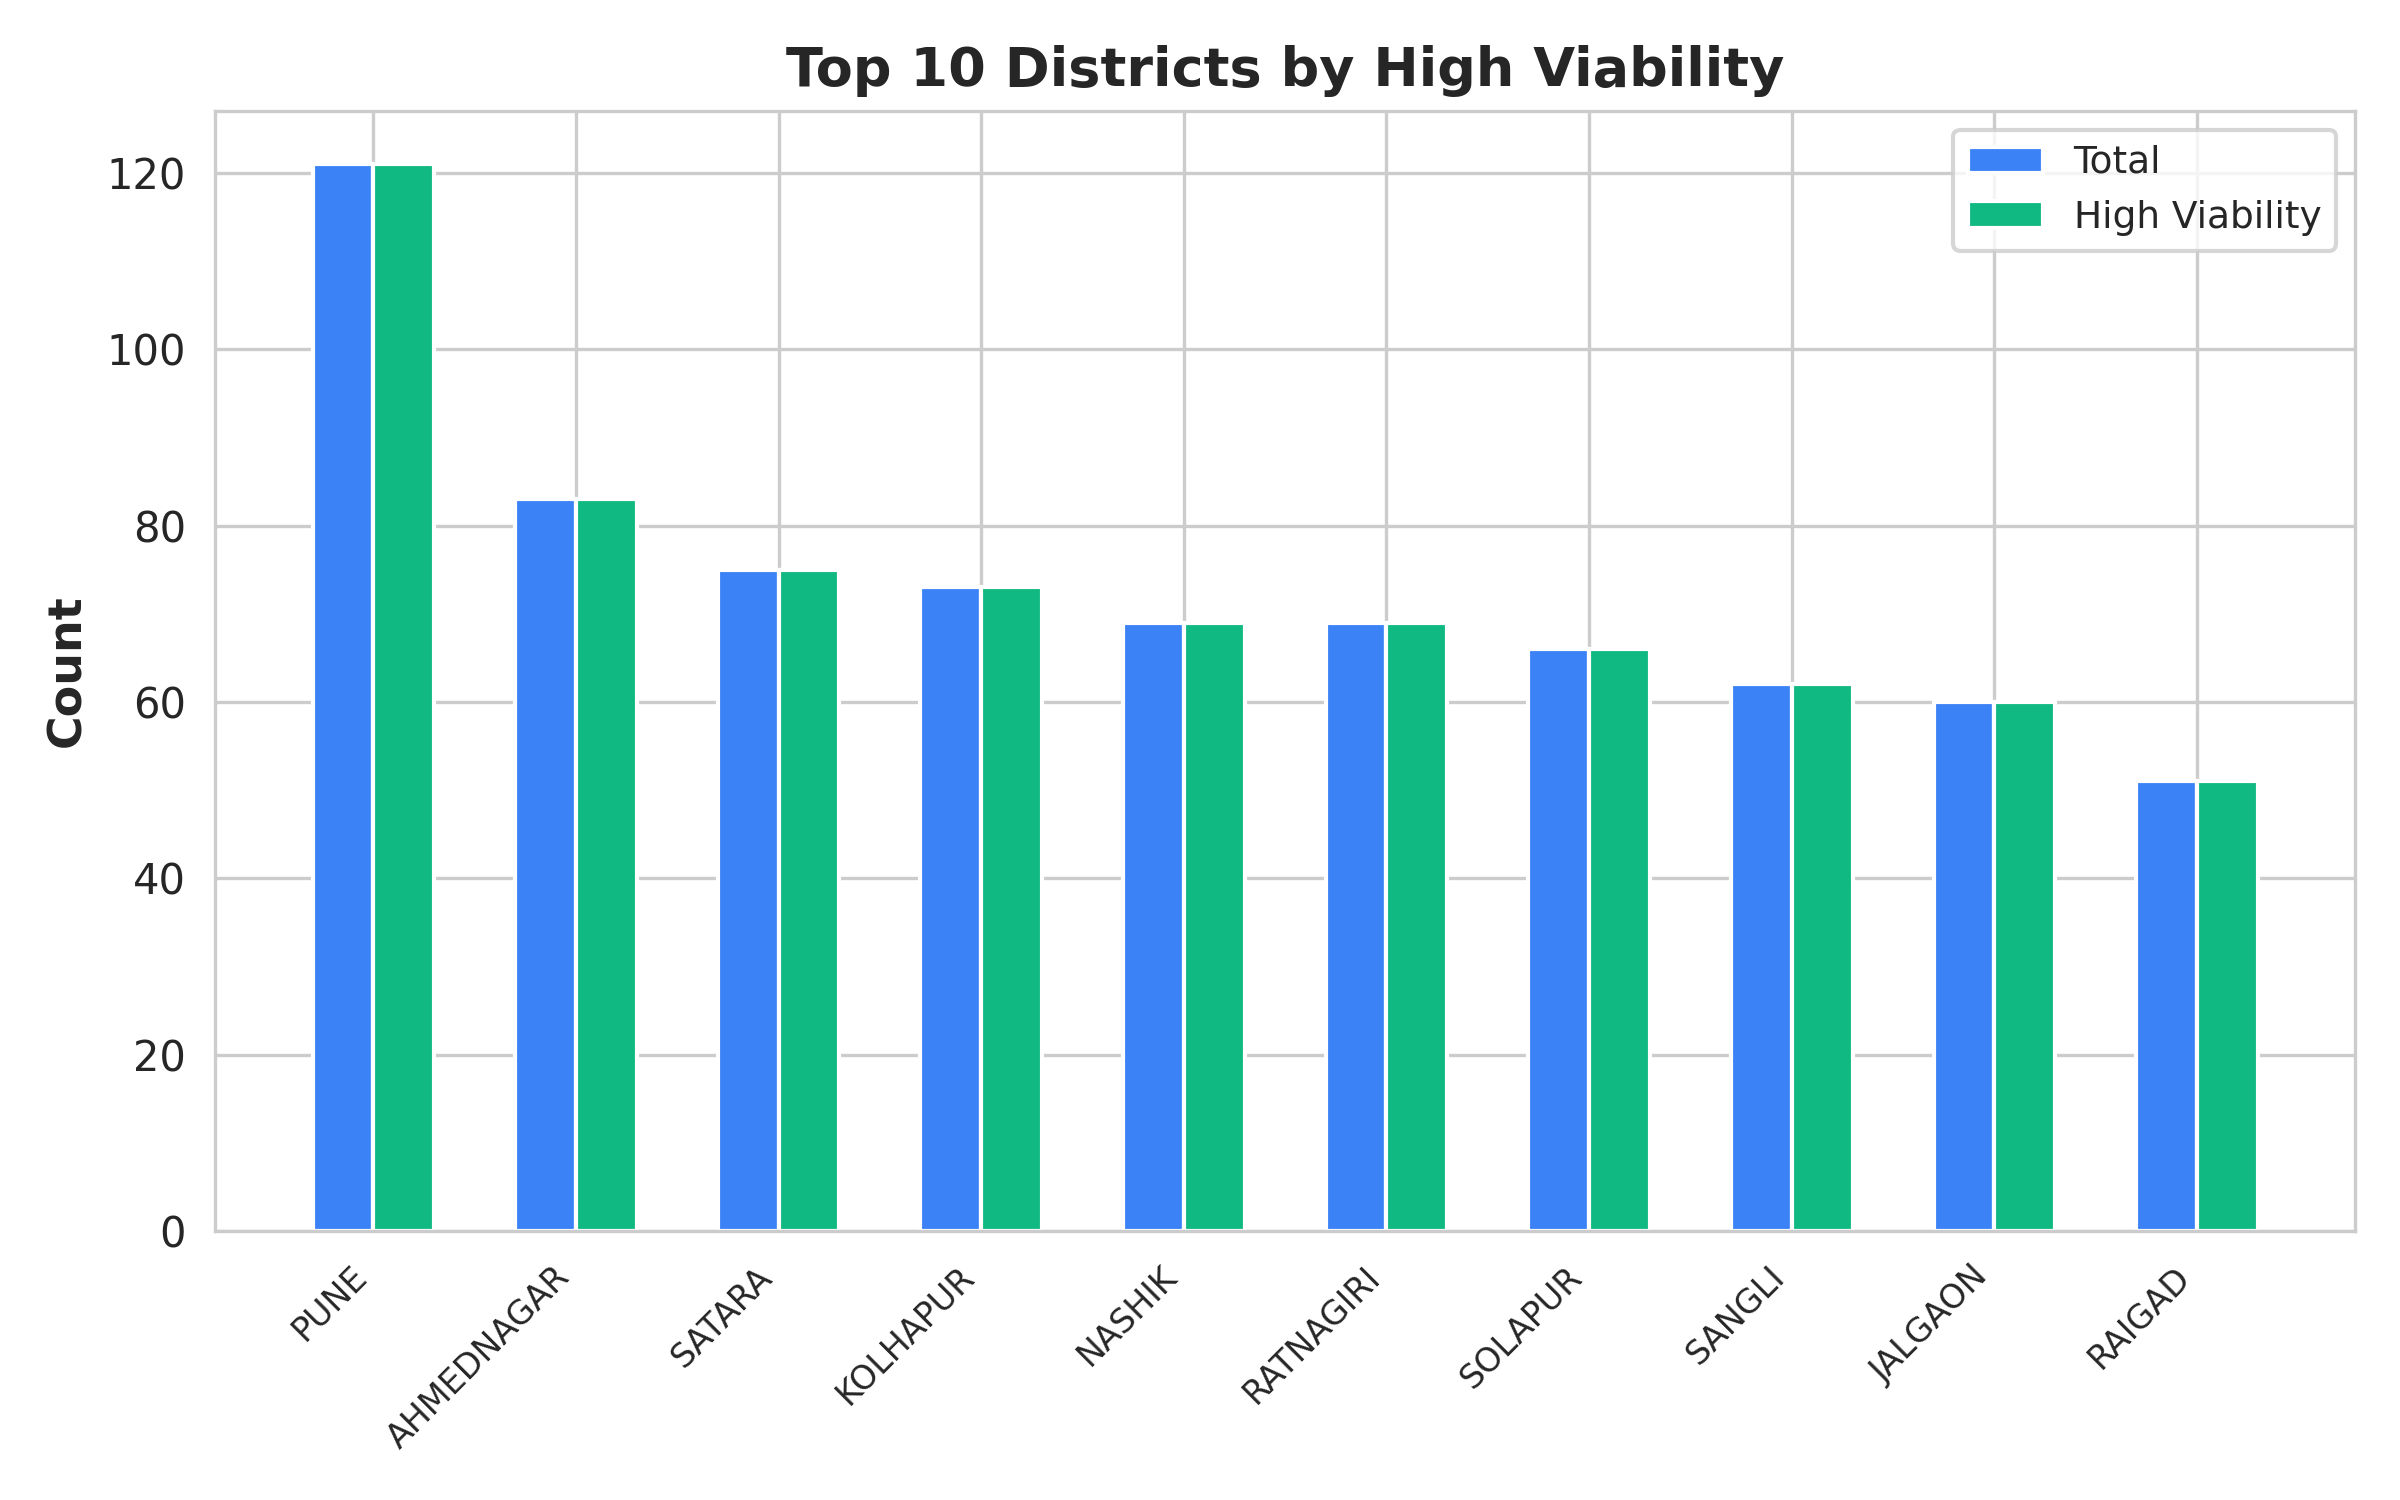

Showing: risk_distribution_small.png


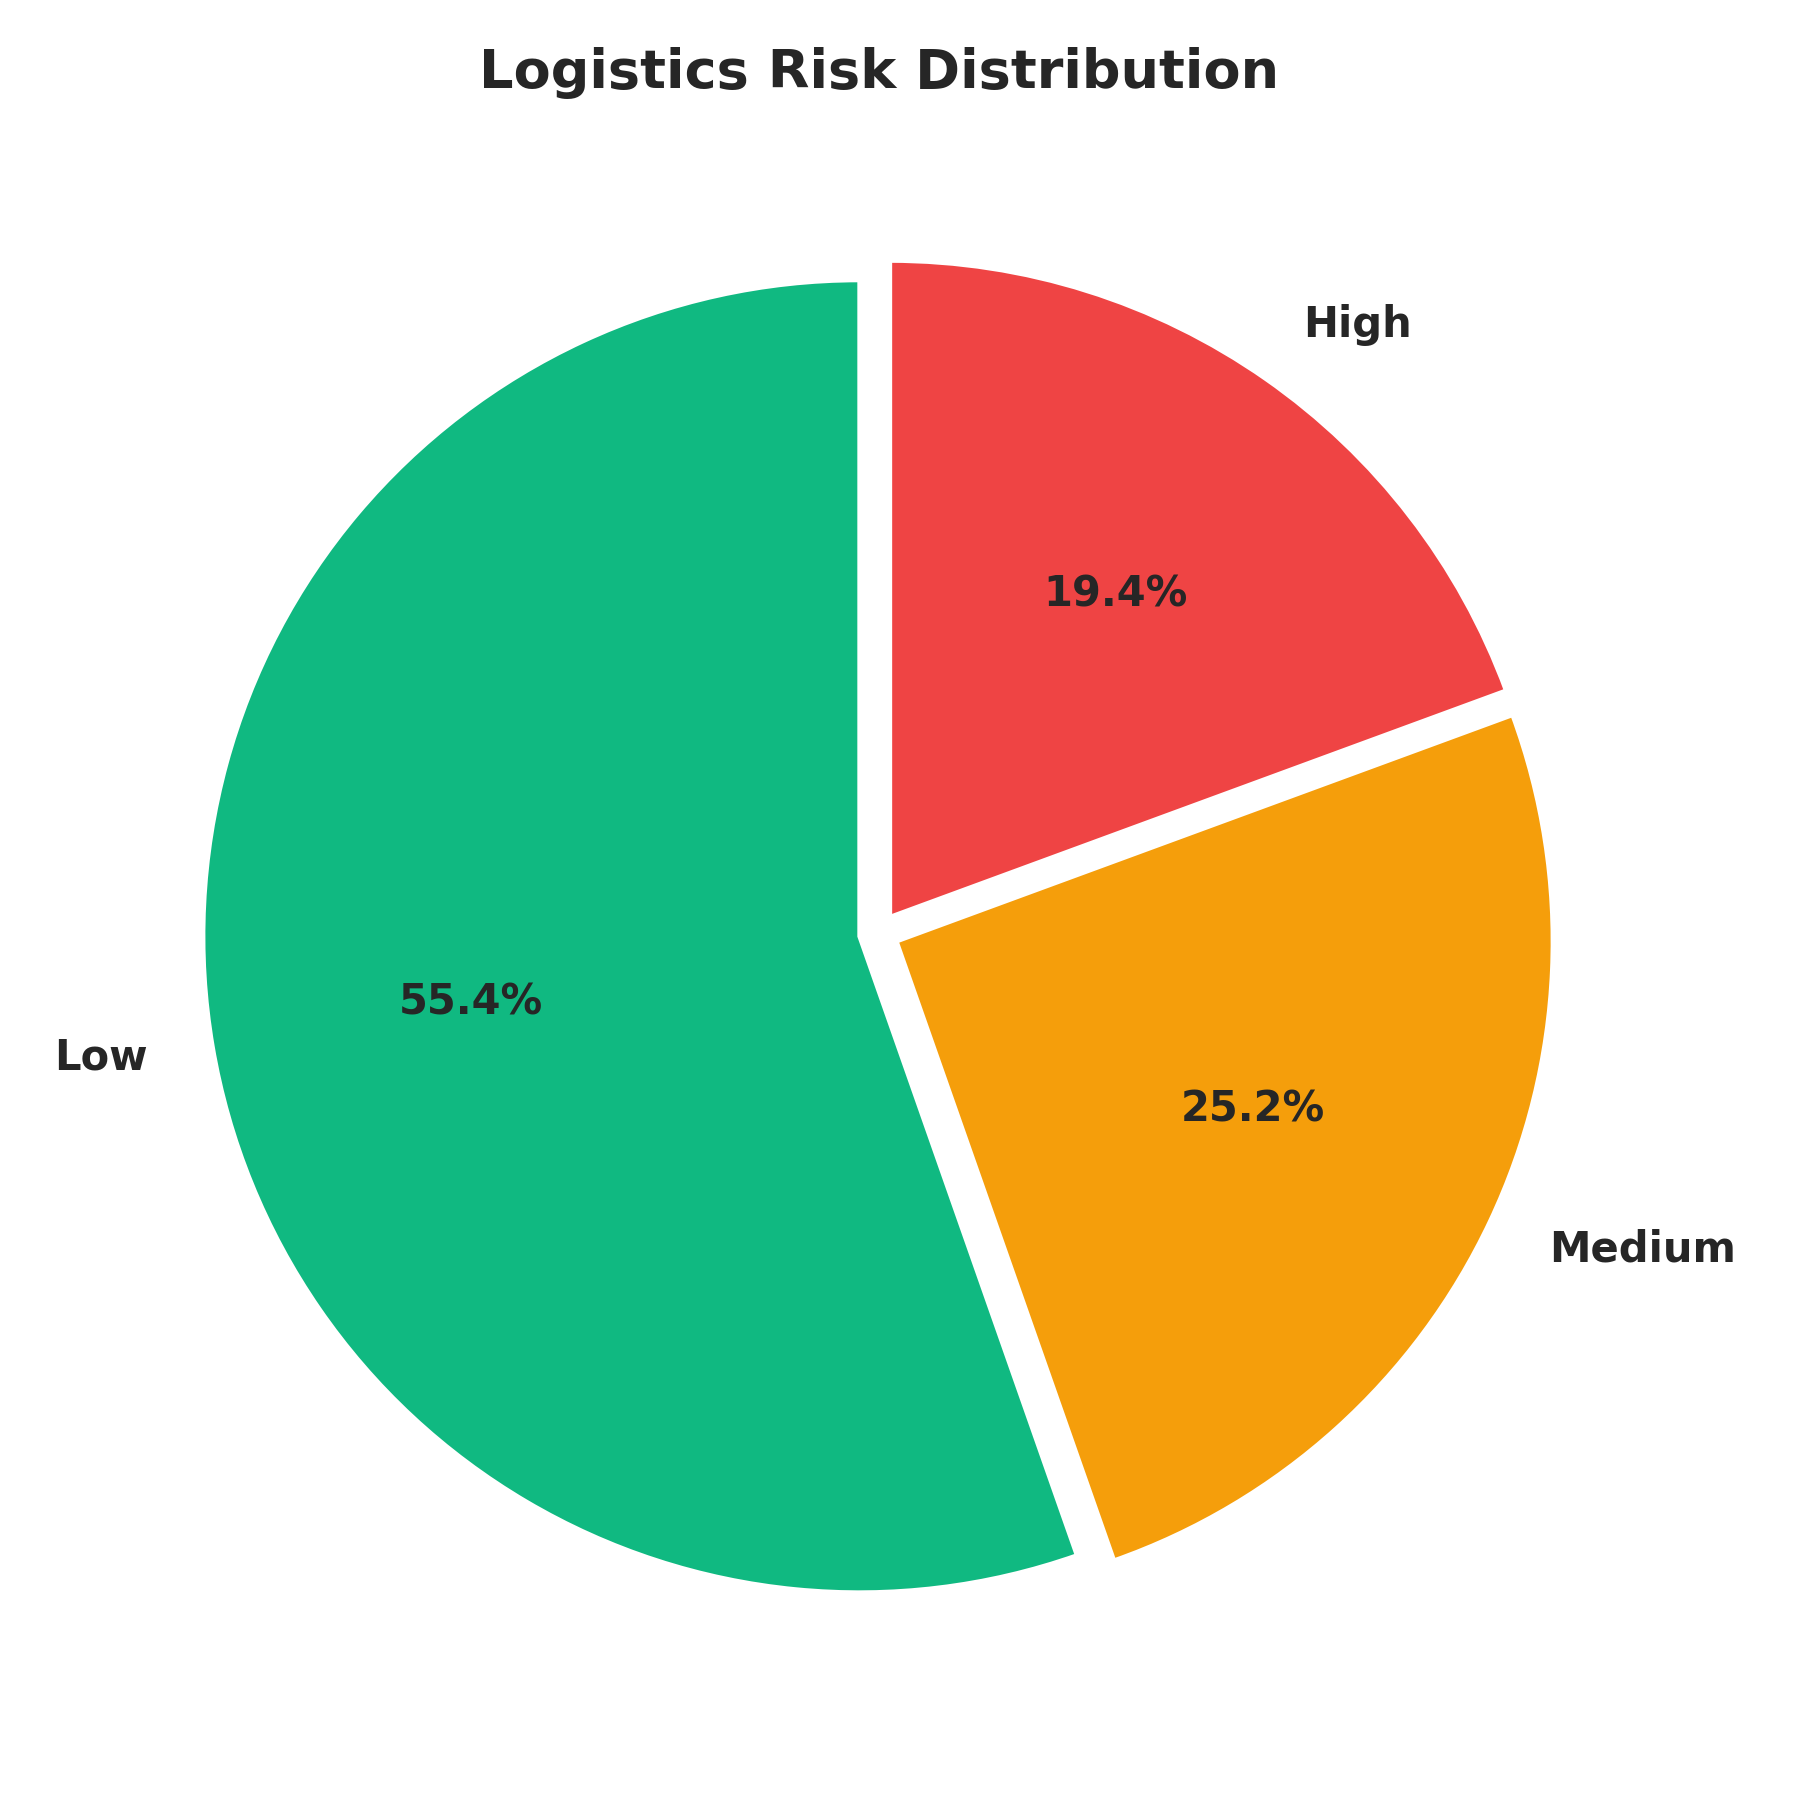

Showing: top20_viability_small.png


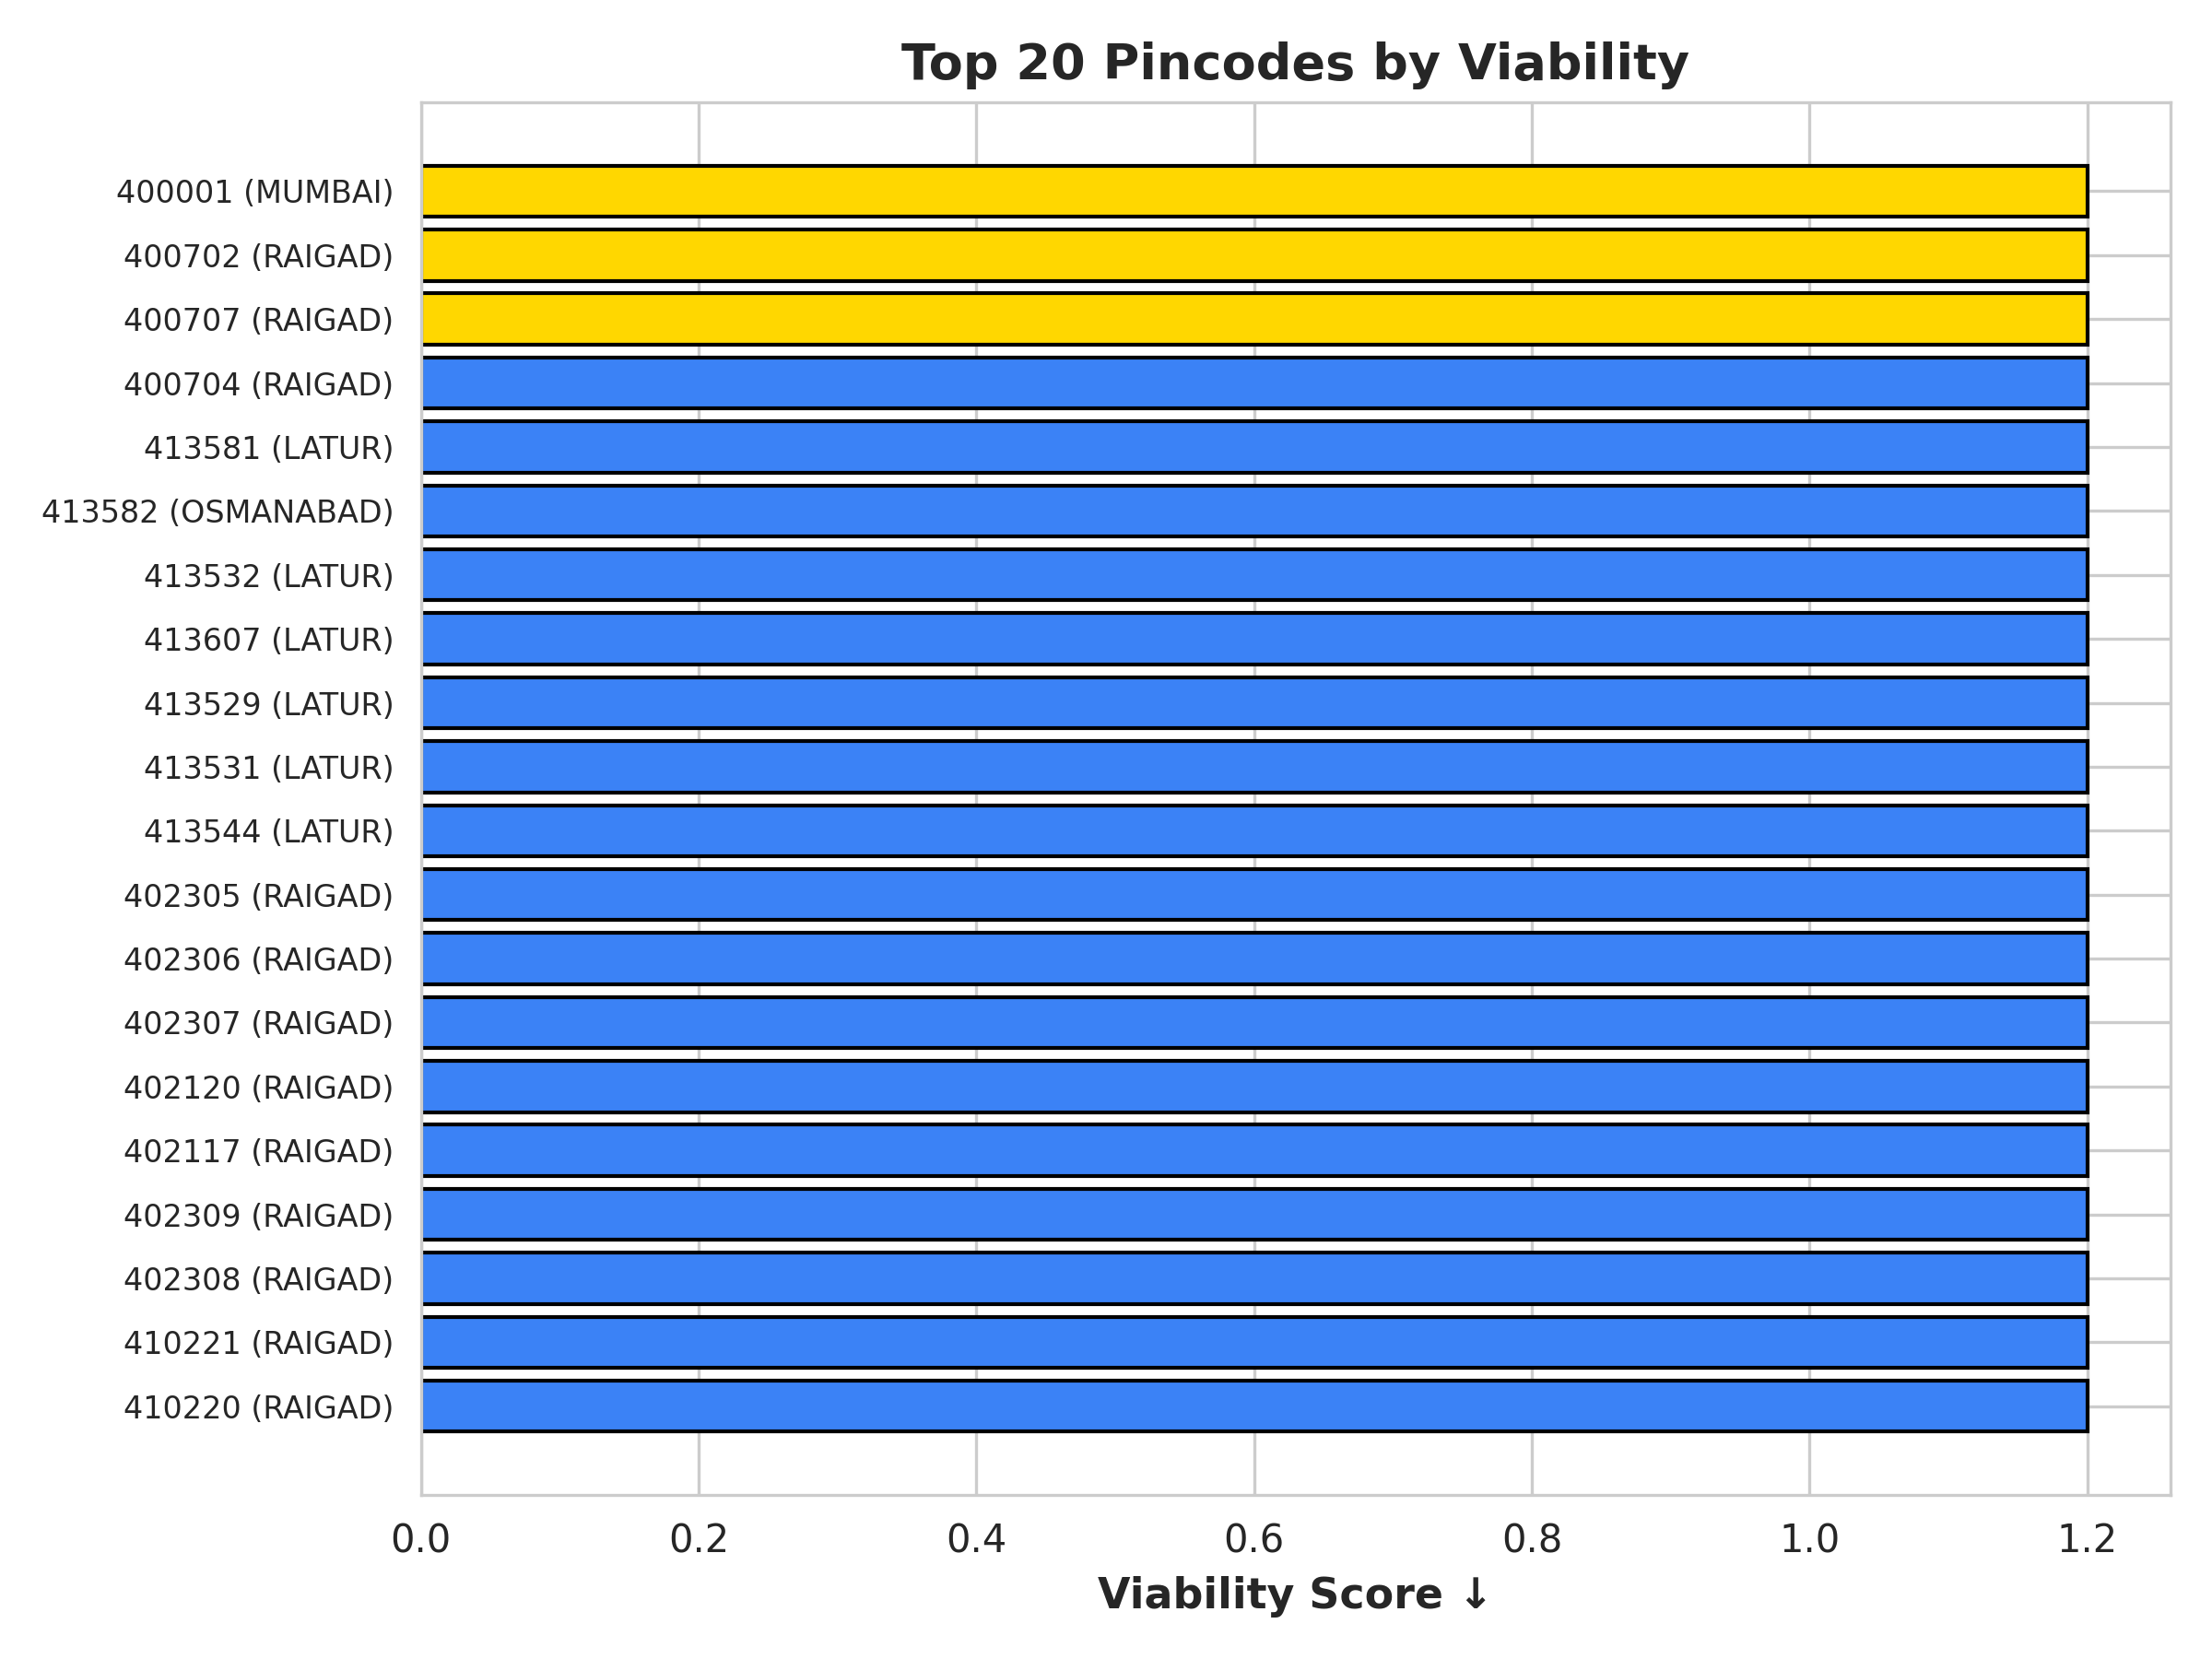

In [22]:
from IPython.display import Image, display
import os

path = "/content/out_q2_small"
for fname in sorted(os.listdir(path)):
    if fname.endswith(".png"):
        print(f"Showing: {fname}")
        display(Image(filename=os.path.join(path, fname)))
